# Title of Your Group Project

This Python notebook serves as a template for your group project on Experiment 1: Two-Armed Bandit Tasks for the course 'Modeling in Cognitive Science'.
This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*

For more information, you can check the task's GitHub repository:
[2 armed bandit task](https://github.com/snamazova/two_armed_bandit_task)



## Data Loading


In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


In [278]:
df = pd.read_json("2armed_bandit.json")

### DataFrame Structure Overview

The DataFrame(df) contains multiple columns representing various aspects of a **two-armed bandit experiment**. Below is a breakdown of the key columns:  

## 1. General Trial Information  
- **`trial_index`**: The index of the current trial in the experiment (note: displaying the score is also considered a trial, as it is a stimulus).  
- **`trial_type`**: The type of trial, indicating how the response was made (e.g., via keyboard or mouse click).  
- **`time_elapsed`**: The total time elapsed (in milliseconds) since the start of the experiment.  
- **`internal_node_id`**: An internal identifier for the trial structure.  

## 2. Response and Stimulus Data  
- **`stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`response`**: The participant’s response/input during the trial.  
- **`rt`**: The reaction time (in milliseconds) taken to respond.  

## 3. Task-Specific Information (Bean Task)    
- **`bean_trial_duration`**: The duration of the bean trial.  
- **`bean_duration`**: The time the bean stimulus was displayed.  
- **`bean_stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`bean_choices`**: The available choice options in the trial.  
- **`bean_correct_key`**: The correct key (button press) for the task.  
- **`bean_type`**: The category of the bean stimulus.  
- **`bean_text`**: A text representation of the bean (if applicable).  
- **`bean_color`**: The color of the bean, which may be relevant to decision-making.  
- **`bean_correct`**: A boolean or categorical value indicating whether the response was correct.  
  - *Note:* In the bandit task, there is no strictly correct choice, as the task focuses on exploration rather than accuracy.  
- **`bean_value`**: The assigned value or reward associated with the bean (bandit).  
- **`bean_score`**: The accumulated score in the experiment.  

## 4. Additional Processing Data  
- **`bean_html_array`**: An HTML representation of the bean stimulus.  
- **`bean_values`**: An array containing value-related information for different beans.  
- **`bean_time_after_response`**: The time elapsed after the participant’s response.  
- **`bean_bandits`**: Information about Bandit 1 and Bandit 2 (their color and value).  


In [279]:
# Display the DataFrame columns to analyze it
df.columns

Index(['rt', 'stimulus', 'response', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'bean_trial_duration',
       'bean_duration', 'bean_stimulus', 'bean_choices', 'bean_correct_key',
       'bean_type', 'bean_text', 'bean_color', 'bean_correct', 'value',
       'bean_html_array', 'bean_values', 'bean_time_after_response',
       'bean_bandits', 'bean_value', 'bean_score'],
      dtype='object')

In [280]:
# drop the bean_value column otherwise we have 2 identical value columns later
df.drop(columns=["bean_value"], inplace=True, axis=1)

# Rename columns for consistency
df.rename(columns=lambda x: x.replace("bean_", ""), inplace=True)
df.rename(columns={"response": "action", "value": "reward"}, inplace=True)

# filter out instructions, by removing any rows from df where the column 'bandits' has NaN
df = df.dropna(subset=["bandits"])

# select the columns we need
df = df[["action", "reward", "values", "score"]]

df.reset_index(drop=True, inplace=True)
df

,action,reward,values,score
0,1,1.0,"[0, 1]",1.0
1,1,1.0,"[1, 1]",2.0
2,0,0.0,"[0, 1]",2.0
3,1,0.0,"[0, 0]",2.0
4,1,0.0,"[0, 0]",2.0
...,...,...,...,...
95,1,1.0,"[0, 1]",66.0
96,1,1.0,"[0, 1]",67.0
97,1,0.0,"[0, 0]",67.0
98,1,0.0,"[0, 0]",67.0


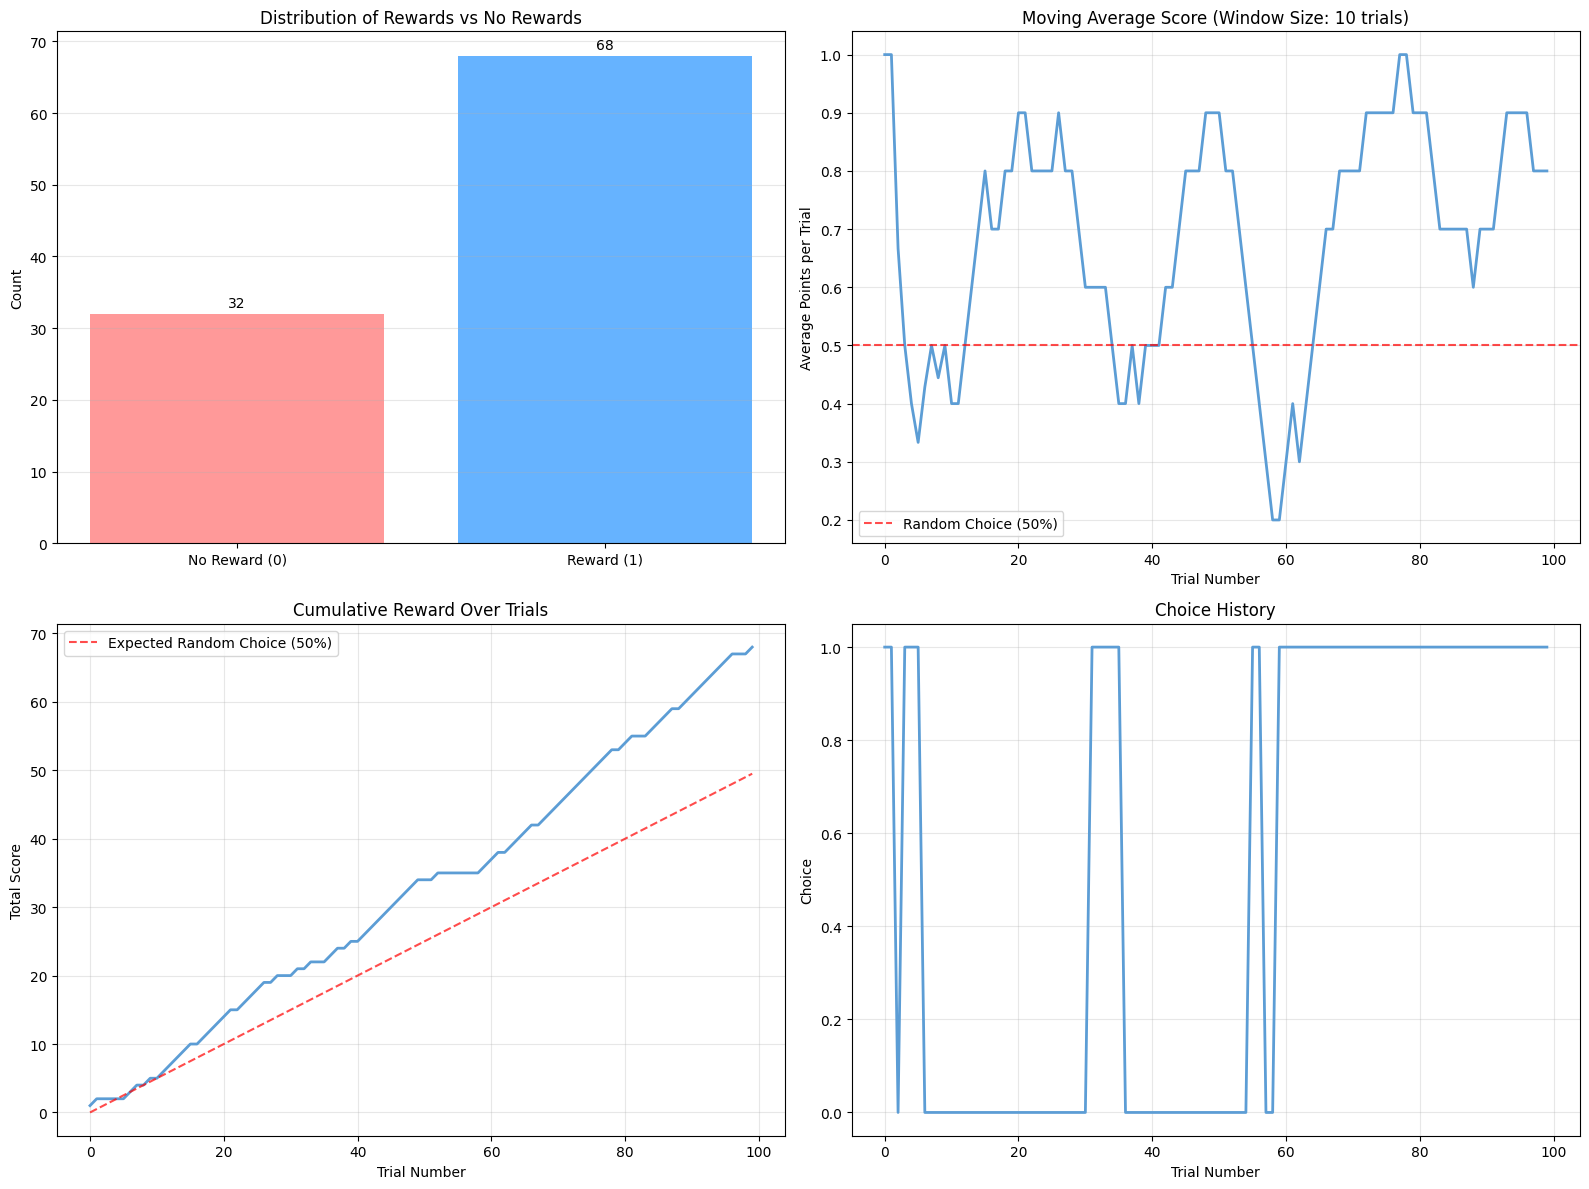

In [281]:
def plot_all_metrics(df, window_size=10, title=None):
    """
    Plot all metrics for a given DataFrame in a 2x2 layout.
    Uses previously defined plotting functions.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot
    window_size : int
        The window size for the moving average score
    title : str, optional
        The title for the overall figure
    """
    # Determine if we have q_values
    has_q_values = 'q_values' in df.columns
    
    # Create a 2x2 figure layout
    fig = plt.figure(figsize=(16, 12))
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    # Plot 1: Reward Distribution (top left)
    ax1 = fig.add_subplot(2, 2, 1)
    reward_counts = df["reward"].value_counts().sort_index()
    ax1.bar(
        ["No Reward (0)", "Reward (1)"],
        reward_counts.values,
        color=["#ff9999", "#66b3ff"],
    )
    ax1.set_title("Distribution of Rewards vs No Rewards")
    ax1.set_ylabel("Count")
    ax1.grid(axis="y", alpha=0.3)
    for i, v in enumerate(reward_counts.values):
        ax1.text(i, v + 1, str(v), ha="center")
    
    # Plot 2: Moving Average Score (top right)
    ax2 = fig.add_subplot(2, 2, 2)
    moving_avg = []
    for i in range(len(df)):
        if i < window_size:
            # For the first few trials, use all available data
            moving_avg.append(df["score"].iloc[i] / (i + 1))
        else:
            # Calculate the average score gain over the last window_size trials
            moving_avg.append(
                (df["score"].iloc[i] - df["score"].iloc[i - window_size]) / window_size
            )
    
    ax2.plot(range(len(moving_avg)), moving_avg, color="#5c9dd5", linewidth=2)
    ax2.axhline(
        y=0.5, color="r", linestyle="--", alpha=0.7, label="Random Choice (50%)"
    )
    ax2.set_title(f"Moving Average Score (Window Size: {window_size} trials)")
    ax2.set_xlabel("Trial Number")
    ax2.set_ylabel("Average Points per Trial")
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    # Plot 3: Cumulative Reward (bottom left)
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(range(len(df)), df["score"], color="#5c9dd5", linewidth=2)
    ax3.plot(
        range(len(df)),
        np.arange(len(df)) * 0.5,
        "r--",
        alpha=0.7,
        label="Expected Random Choice (50%)",
    )
    ax3.set_title("Cumulative Reward Over Trials")
    ax3.set_xlabel("Trial Number")
    ax3.set_ylabel("Total Score")
    ax3.grid(alpha=0.3)
    ax3.legend()
    
    # Plot 4: Either Q-Values or Choice History (bottom right)
    ax4 = fig.add_subplot(2, 2, 4)
    if has_q_values:
        q_values = np.array(df["q_values"].tolist())
        ax4.plot(range(len(df)), q_values[:, 0], "b-", label="Arm 0 Q-value")
        ax4.plot(range(len(df)), q_values[:, 1], "g-", label="Arm 1 Q-value")
        ax4.set_title("Q-Values Over Trials")
        ax4.set_xlabel("Trial Number")
        ax4.set_ylabel("Q-Value")
        ax4.grid(alpha=0.3)
        ax4.legend()
    else:
        # If no q_values, show choice history instead
        ax4.plot(range(len(df)), df["action"], color="#5c9dd5", linewidth=2)
        ax4.set_title("Choice History")
        ax4.set_xlabel("Trial Number")
        ax4.set_ylabel("Choice")
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.93)  # Adjust for the suptitle
    plt.show()


# plotting the data
plot_all_metrics(df, window_size=10)

## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [282]:
# Helper functions
def softmax(x, beta=1):
    exp_values = np.exp(x * beta)
    return exp_values / np.sum(exp_values)


def generate_surrogate_data(probs, total_trials, trial_number_probaility_change):
    surrogate_data = []
    for i in range(total_trials):
        if i < trial_number_probaility_change:
            surrogate_data.append(
                [int(random.random() <= probs[0]), int(random.random() <= probs[1])]
            )
        else:
            surrogate_data.append(
                [int(random.random() <= probs[1]), int(random.random() <= probs[0])]
            )
    return surrogate_data


def get_reward(action, rewards):
    return rewards[action]


def log_data(df, trial_number, action, reward, values, q_values=None):
    """
    Log trial data to the DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to log data to
    trial_number : int
        The current trial number
    action : int
        The action taken (0 or 1)
    reward : float
        The reward received
    values : list
        The true reward values for each arm
    q_values : numpy.ndarray
        The current Q-values for each arm

    Returns:
    --------
    pandas.DataFrame
        The updated DataFrame
    """
    # Calculate cumulative score
    if df.empty:
        score = reward
    else:
        score = df["score"].iloc[-1] + reward

    # Create a new row with all the data
    new_row = pd.DataFrame(
        {
            "action": [action],
            "reward": [reward],
            "values": [values],
            "score": [score],
        }
    )
    if q_values is not None:
        new_row["q_values"] = [
            q_values.copy()
        ]  # Store a copy of the entire q_values array if provided

    # Append the new row to the DataFrame
    df = pd.concat([df, new_row], ignore_index=True)
    return df


In [283]:
# base abstract model class
class AbstractModel:
    def __init__(self, learning_rate, beta):
        self.learning_rate = learning_rate
        self.q_values = np.zeros(num_arms)
        self.beta = beta

    def choose_action(self):
        # using the softmax function to choose the action
        probabilities = softmax(self.q_values, self.beta)
        return np.random.choice(range(len(probabilities)), p=probabilities)

    def update(self, action, reward):
        pass

    def get_q_values(self):
        return self.q_values


# basic model
# only updates the option that was chosen
class BasicModel(AbstractModel):
    def update(self, action, reward):
        # updating the q_values using the formula Qt(a) = Qt−1(a) + α · (rt − Qt−1(a))
        self.q_values[action] = self.q_values[action] + self.learning_rate * (
            reward - self.q_values[action]
        )


# Second more complex model
# This model also updates the option that was not chosen
class ComplexModel(AbstractModel):
    def __init__(self, learning_rate, beta, curiosity):
        super().__init__(learning_rate, beta)
        self.curiosity = curiosity

    def update(self, action, reward):
        # updating the q_values using the formula Qt(a) = Qt−1(a) + α · (rt − Qt−1(a))
        self.q_values[action] = self.q_values[action] + self.learning_rate * (
            reward - self.q_values[action]
        )
        self.q_values[1 - action] = self.q_values[1 - action] + self.curiosity * (
            1 - reward - self.q_values[1 - action]
        )


# Third model, based on the simple rule:
# choose the winning options unitl it lost 2 times then switch to the other option
class RuleBasedModel:
    def __init__(self, loss_threshold=2):
        self.losses = 0
        self.current_choice = random.choice([0, 1])
        self.loss_threshold = loss_threshold

    def choose_action(self):
        # if the model has lost 2 times, it will switch to the other option
        if self.losses >= self.loss_threshold:
            self.losses = 0
            self.current_choice = 1 - self.current_choice
            return self.current_choice
        # otherwise stay with the current choice
        else:
            return self.current_choice

    def update(self, reward):
        self.losses += 1 - reward

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. The model plots should depict key features of the behavioral data, convincing yourself that the models are suitable to capture the data. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [284]:
# trial parameters
num_arms = 2  # number of options
probs = [0.8, 0.2]  # probability of the chosen option
trial_probaility_change = 50  # number of trials to change the probability of the chosen option
total_trials = 100  # total number of trials

# model parameters
learning_rate = 0.2  # update rate of the q_values
curiosity = 0.2  # parameter for update the q_values of the non chosen option
beta = 3  # parameter for the softmax function
loss_threshold = (
    2  # number of losses before switching to the other option for RuleBasedModel
)


df_basic = pd.DataFrame(columns=["action", "reward", "values", "score", "q_values"])
df_complex = pd.DataFrame(columns=["action", "reward", "values", "score", "q_values"])
df_rule_based = pd.DataFrame(columns=["action", "reward", "values", "score"])

# generate surrogate data
surrogate_data = generate_surrogate_data(
    probs, total_trials, trial_probaility_change
)

# initialize the models
basic_model = BasicModel(learning_rate, beta)
complex_model = ComplexModel(learning_rate, beta, curiosity)
rule_based_model = RuleBasedModel(loss_threshold)


def simulate_RL_model(model, df, data):
    # repeat the simulation for each trial
    for trial in range(total_trials):
        # choose the action
        action = model.choose_action()
        # get the reward
        reward = get_reward(action, data[trial])
        # update the model
        model.update(action, reward)
        # log the data
        df = log_data(df, trial, action, reward, data[trial], model.get_q_values())
    return df


def simulate_rule_based_model(model, df, data):
    # repeat the simulation for each trial
    for trial in range(total_trials):
        # choose the action
        action = model.choose_action()
        # get the reward
        reward = get_reward(action, data[trial])
        # update the model
        model.update(reward)
        # log the data
        df = log_data(df, trial, action, reward, data[trial])
    return df


# simulate all models
df_basic = simulate_RL_model(basic_model, df_basic, surrogate_data)
df_complex = simulate_RL_model(complex_model, df_complex, surrogate_data)
df_rule_based = simulate_rule_based_model(rule_based_model, df_rule_based, surrogate_data)

df_basic

,action,reward,values,score,q_values
0,0,0,"[0, 0]",0,"[0.0, 0.0]"
1,1,1,"[0, 1]",1,"[0.0, 0.2]"
2,1,0,"[1, 0]",1,"[0.0, 0.16]"
3,0,1,"[1, 0]",2,"[0.2, 0.16]"
4,0,1,"[1, 0]",3,"[0.36000000000000004, 0.16]"
...,...,...,...,...,...
95,1,1,"[0, 1]",59,"[0.1740233216953379, 0.8482384511235198]"
96,1,0,"[0, 0]",59,"[0.1740233216953379, 0.6785907608988159]"
97,1,1,"[1, 1]",60,"[0.1740233216953379, 0.7428726087190527]"
98,1,1,"[1, 1]",61,"[0.1740233216953379, 0.7942980869752422]"


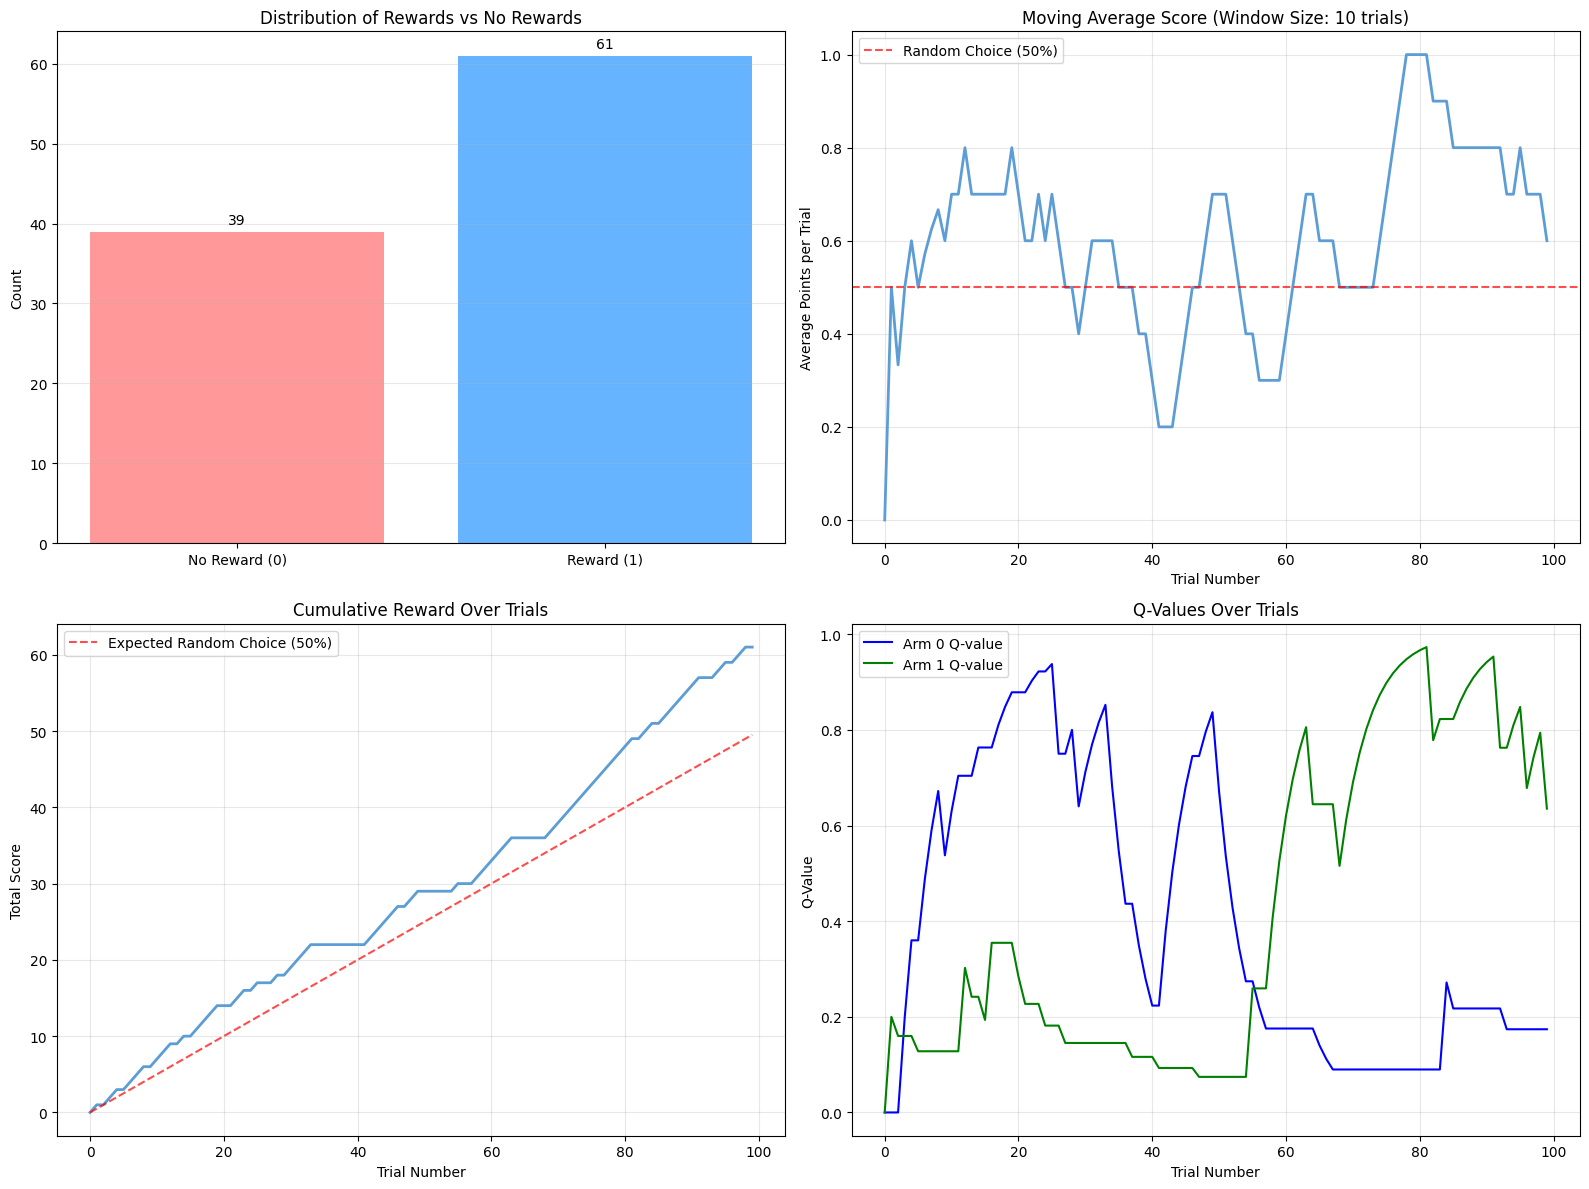

In [285]:
# plot the data of the basic model
plot_all_metrics(df_basic, window_size=10)

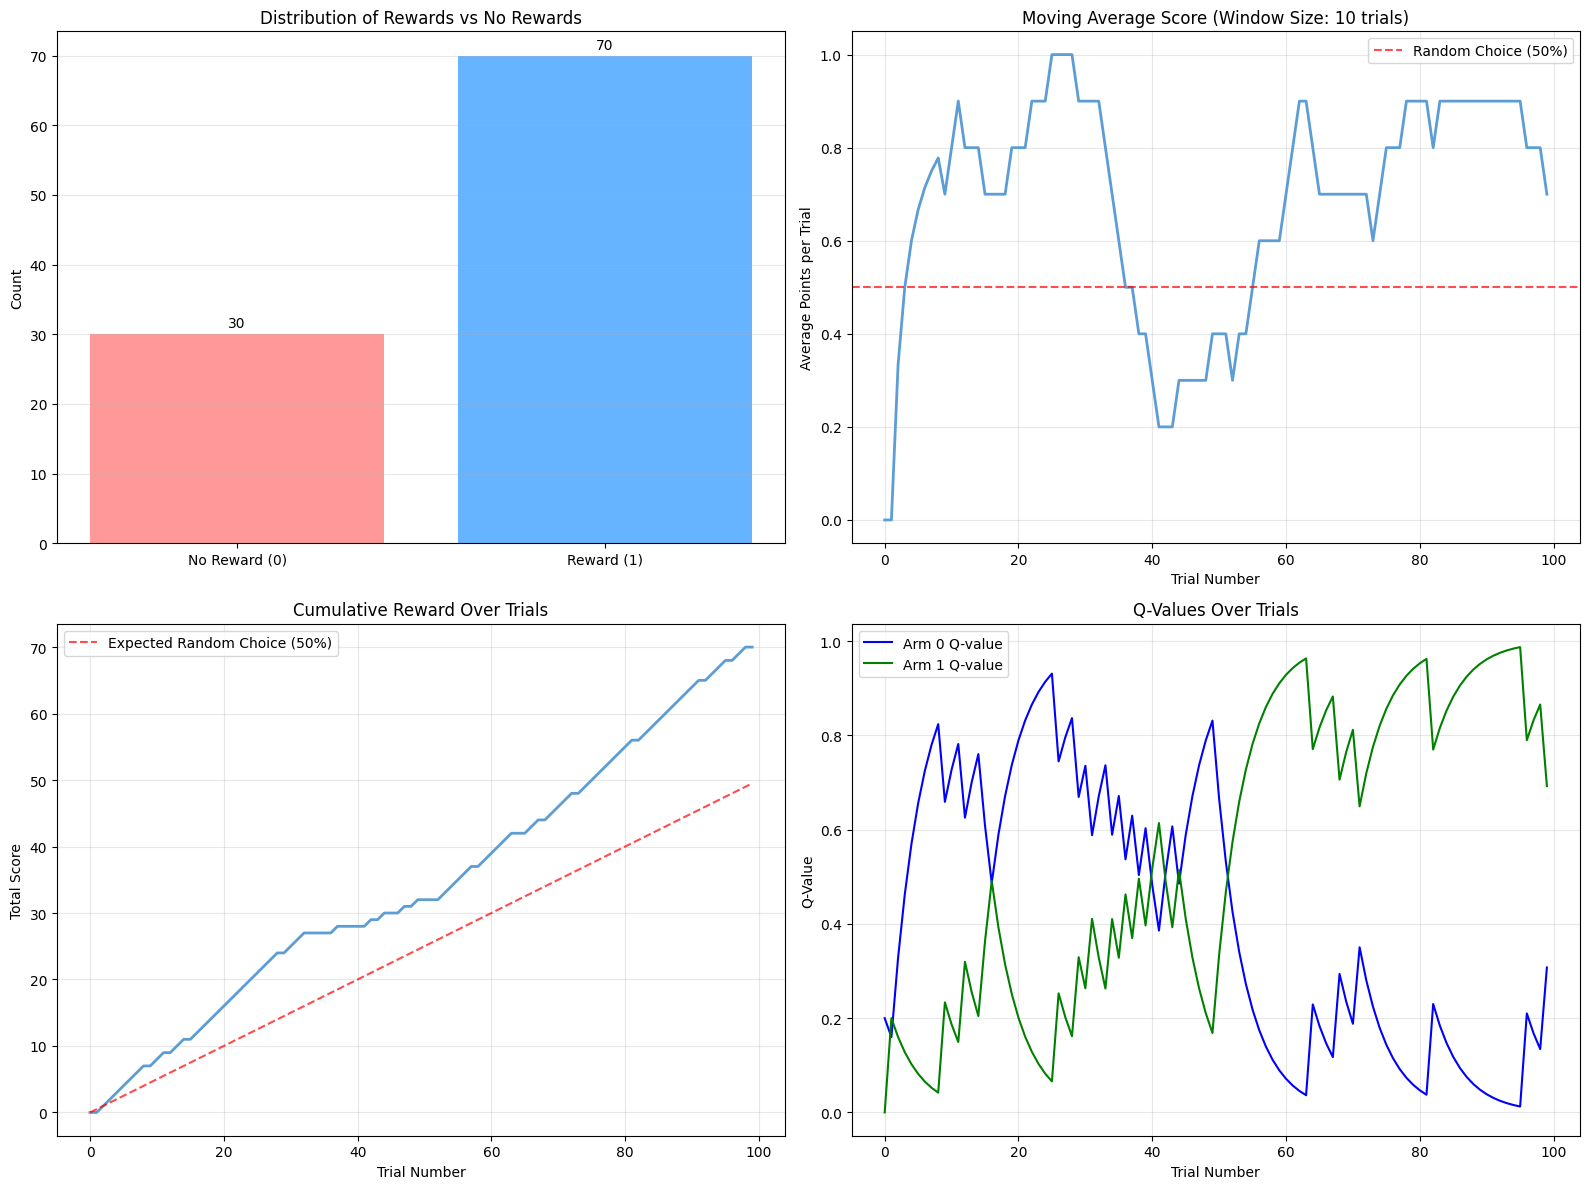

In [286]:
# plot the data of the complex model
plot_all_metrics(df_complex, window_size=10)

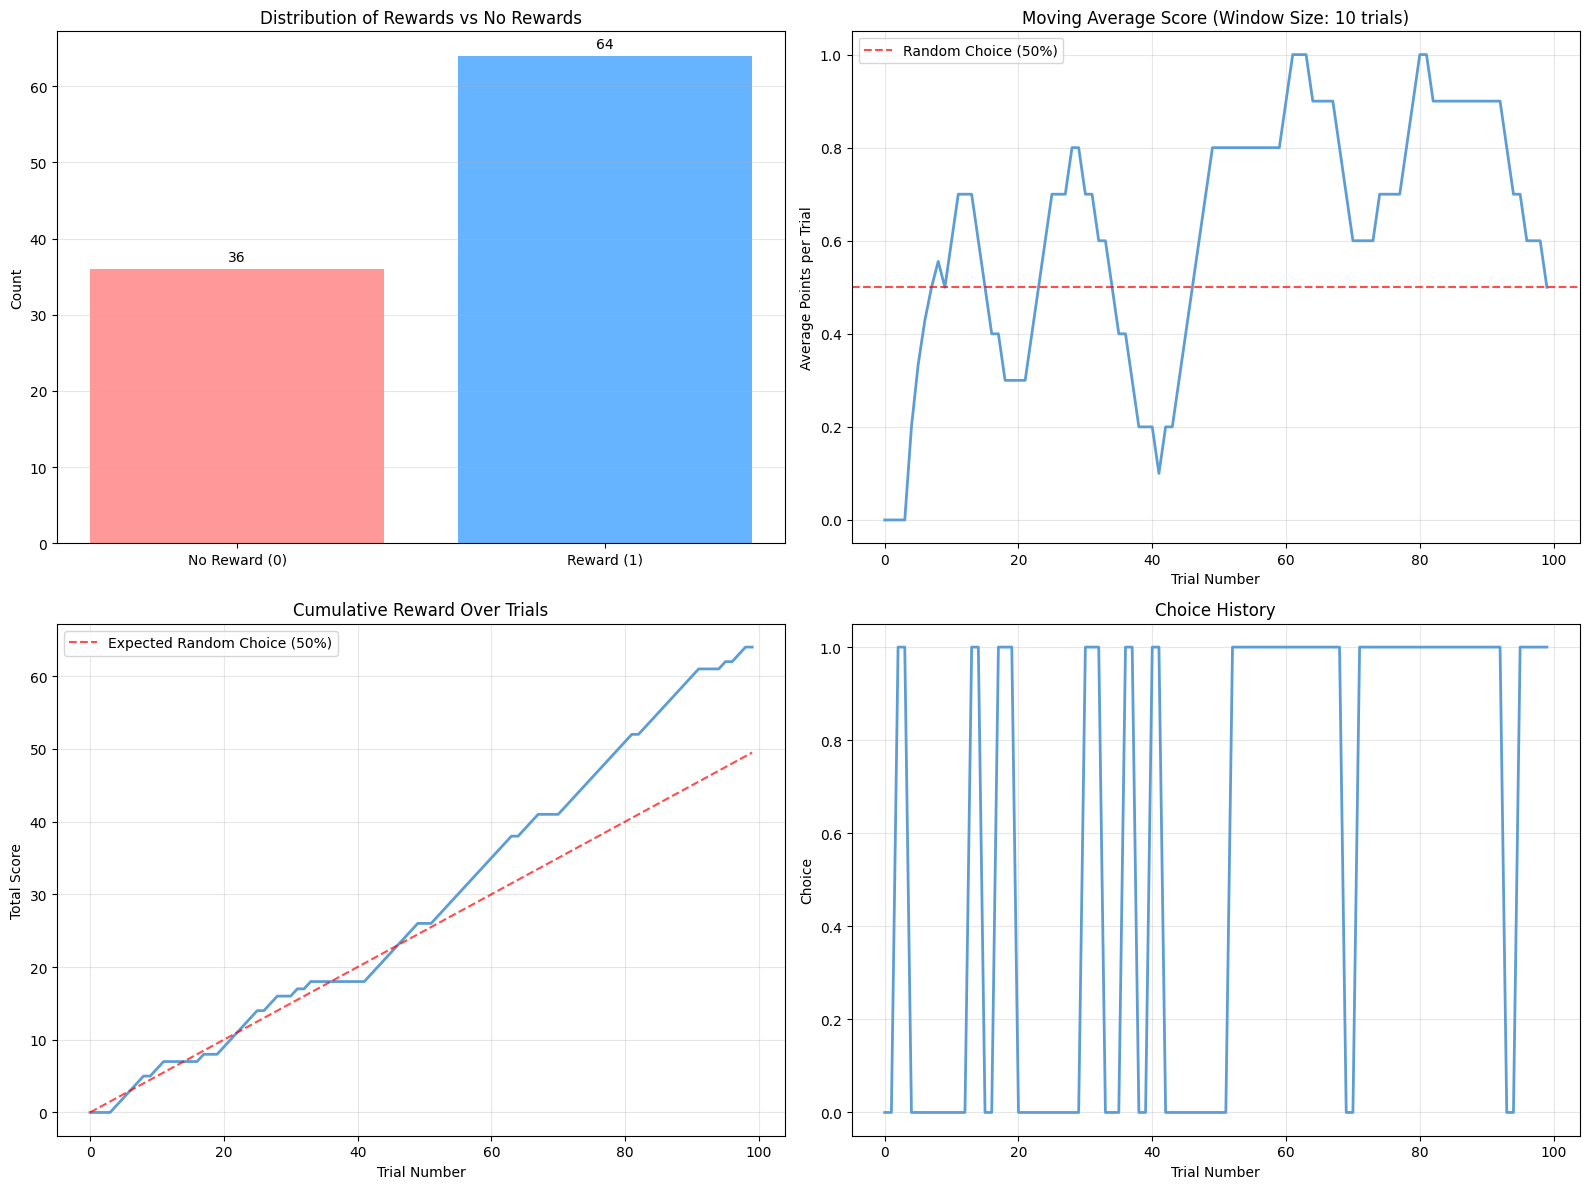

In [287]:
# rule based model
plot_all_metrics(df_rule_based, window_size=10)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [288]:

def log_likelihood(model, data):
    LL = 0
    
    # repeat the simulation for each trial
    for trial in range(total_trials):
        observed_action = data[trial]["action"]
        
        # choose the action
        action = model.choose_action()
        
        # update the LL
        LL += np.log(model.get_action_probability(action))
        
        
        

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [289]:
# YOUR PARAMETER RECOVERY CODE GOES HERE

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [290]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [291]:
# YOUR MODEL COMPARISON CODE GOES HERE